In [1]:
import numpy as np
import cv2, random
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
img = cv2.imread('images/test.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale

noise = np.random.rand(512, 512)

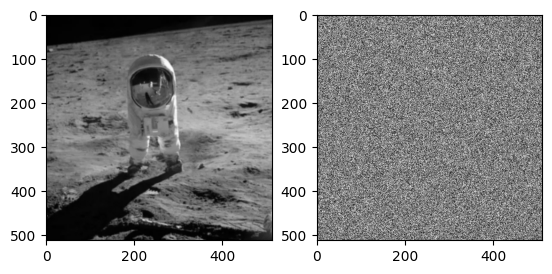

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(gray_img, 'gray')
axs[1].imshow(noise, 'gray')